# Real estates pricing with Python
### Analysis of real estate prices in Singapore
#### Author: Petar Sarajcev, PhD; University of Split, FESB, Croatia. (petar.sarajcev@fesb.hr)

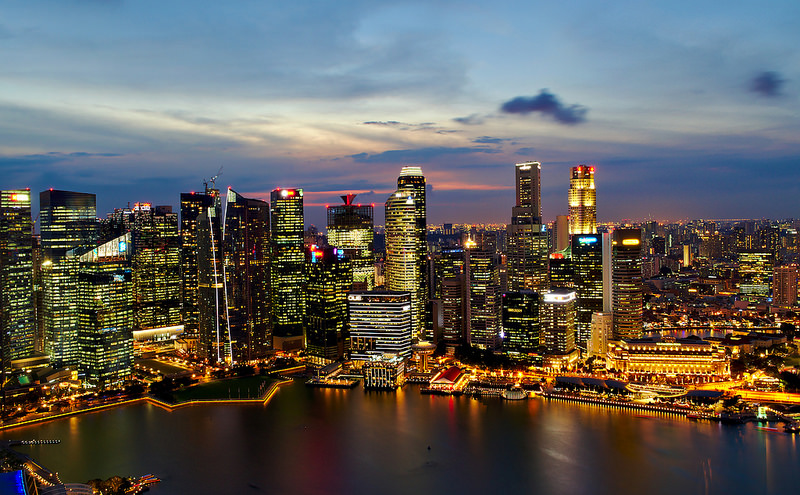

In [6]:
Image(filename='singapore.jpg', width=800, height=500)

Inspired by: https://www.youtube.com/watch?v=PInO2Cluu2E&list=PLECEw2eFfW7iTsIrldRO2b6NLEuRQYD2L&index=23

In [1]:
from __future__ import print_function

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

import folium
from folium import plugins

import shapefile
import colorsys
import pickle
import time
import warnings

from geopy.geocoders import Nominatim
from geopy.distance import great_circle
from IPython.display import Image, HTML
from collections import OrderedDict

import tensorflow as tf
from tensorflow.contrib import learn

from sklearn import preprocessing
from sklearn import metrics
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import make_pipeline

In [3]:
# Disable warnings emitted by warnings.warn calls from different packages
warnings.filterwarnings('ignore')

In [4]:
# Set style for plots (seaborn)
sns.set_context('notebook', font_scale=1.25)
sns.set_style('darkgrid')

In [5]:
# Matplotlib inline plots
%matplotlib inline

### Urban Redevelopment Authority of Singapore
#### Dataset lists real estates sold in the period: July-2015 to July-2016 within the select districts of Singapore

https://www.ura.gov.sg/uol/

In [6]:
# Read data as csv (first part)
s01 = pd.read_csv('singapore-part-01.csv', skiprows=1)
s01 = s01.dropna()
s01 = s01[s01['Postal District']!=1.0]  # remove postal district 01 (it is also in singapore.csv!)
(s01['Postal District']==1.0).sum()  # if 0 then ok

0

In [7]:
# Read data as csv (second part)
s02 = pd.read_csv('singapore-part-02.csv', skiprows=1)
s02 = s02.dropna()
# Read data as csv (third part)
s03 = pd.read_csv('singapore.csv', skiprows=1)
s03 = s03.dropna()

In [8]:
# Merge datasets into a single database
sing = s01.append(s02, ignore_index=True)
sing = sing.append(s03, ignore_index=True)
singapore = sing.set_index(pd.to_datetime(sing['Date of Sale'].values, infer_datetime_format=True))
del singapore['S/N']
del singapore['Date of Sale']
del singapore['Nett Price ($)']

In [9]:
singapore.head(10)

,Project Name,Street Name,Type,Postal District,Market Segment,Tenure,Type of Sale,No. of Units,Price ($),Area (Sqm),Type of Area,Floor Level,Unit Price ($psm)
2016-07-01,SKYLINE RESIDENCES,TELOK BLANGAH ROAD,Condominium,4.0,RCR,Freehold,Resale,1.0,970000.0,45.0,Strata,21 to 25,21556.0
2016-07-01,THE INTERLACE,DEPOT ROAD,Condominium,4.0,RCR,99 yrs lease commencing from 2009,Resale,1.0,2245000.0,191.0,Strata,01 to 05,11754.0
2016-07-01,CLEMENTIWOODS CONDOMINIUM,WEST COAST ROAD,Condominium,5.0,OCR,99 yrs lease commencing from 2006,Resale,1.0,1130000.0,98.0,Strata,01 to 05,11531.0
2016-07-01,THE TRILINQ,JALAN LEMPENG,Condominium,5.0,OCR,99 years leasehold,New Sale,1.0,831000.0,50.0,Strata,21 to 25,16620.0
2016-07-01,THE TRILINQ,JALAN LEMPENG,Condominium,5.0,OCR,99 years leasehold,New Sale,1.0,1294000.0,85.0,Strata,16 to 20,15224.0
2016-07-01,THE TRILINQ,JALAN LEMPENG,Condominium,5.0,OCR,99 years leasehold,New Sale,1.0,1294000.0,87.0,Strata,26 to 30,14874.0
2016-07-01,THE TRILINQ,JALAN LEMPENG,Condominium,5.0,OCR,99 years leasehold,New Sale,1.0,1120000.0,65.0,Strata,26 to 30,17231.0
2016-07-01,PRINCIPAL GARDEN,PRINCE CHARLES CRESCENT,Condominium,3.0,RCR,99 years leasehold,New Sale,1.0,1796000.0,100.0,Strata,16 to 20,17880.0
2016-07-01,HIGHLINE RESIDENCES,KIM TIAN ROAD,Condominium,3.0,RCR,99 years leasehold,New Sale,1.0,1640000.0,84.0,Strata,21 to 25,19524.0
2016-07-01,PRINCIPAL GARDEN,PRINCE CHARLES CRESCENT,Condominium,3.0,RCR,99 years leasehold,New Sale,1.0,869000.0,47.0,Strata,11 to 15,18319.0


Projects in this database are grouped by Core Central Region (CCR), Rest of Central Region (RCR) and Outside Central Region (OCR). Price ($) refers to the purchase price stated in the Option and S&P agreement and would have already deducted upfront direct discounts (e.g. early bird discount), if any.

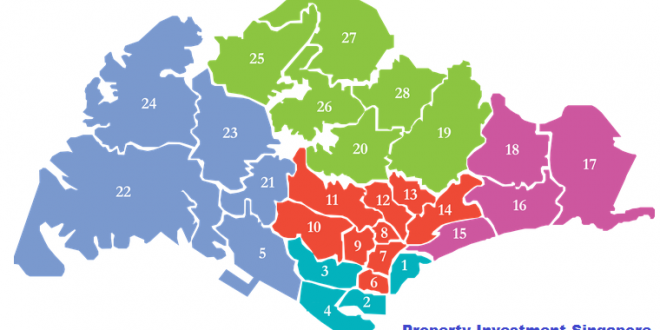

In [10]:
# Map of Singapore postal districts
Image(filename='singapore-district-map.png', width=600, height=500)

In [11]:
# Largest real estate by area sold
singapore[singapore['Area (Sqm)']==singapore['Area (Sqm)'].max()]

,Project Name,Street Name,Type,Postal District,Market Segment,Tenure,Type of Sale,No. of Units,Price ($),Area (Sqm),Type of Area,Floor Level,Unit Price ($psm)
2016-06-01,THE NASSIM,NASSIM HILL,Condominium,10.0,CCR,Freehold,Resale,1.0,20250000.0,837.0,Strata,01 to 05,24194.0


In [12]:
# Most expensive square meter of real estate in Singapore
singapore[singapore['Unit Price ($psm)']==singapore['Unit Price ($psm)'].max()]

,Project Name,Street Name,Type,Postal District,Market Segment,Tenure,Type of Sale,No. of Units,Price ($),Area (Sqm),Type of Area,Floor Level,Unit Price ($psm)
2016-06-01,LE NOUVEL ARDMORE,ARDMORE PARK,Condominium,10.0,CCR,Freehold,Resale,1.0,21000000.0,487.0,Strata,06 to 10,43121.0


In [13]:
# Most expensive real estate sold in the last year
singapore[singapore['Price ($)']==singapore['Price ($)'].max()]

,Project Name,Street Name,Type,Postal District,Market Segment,Tenure,Type of Sale,No. of Units,Price ($),Area (Sqm),Type of Area,Floor Level,Unit Price ($psm)
2015-08-01,BISHOPSGATE RESIDENCES,BISHOPSGATE,Condominium,10.0,CCR,Freehold,Resale,1.0,21071994.0,565.0,Strata,01 to 05,37296.0


In [14]:
# Real estate size statistics
singapore['Area (Sqm)'].describe()

count    5696.000000
mean      103.633954
std        58.158914
min        30.000000
25%        63.000000
50%        95.000000
75%       124.000000
max       837.000000
Name: Area (Sqm), dtype: float64

In [15]:
# Price per square-meter statistics
singapore['Unit Price ($psm)'].describe()

count     5696.000000
mean     15292.277563
std       4489.557431
min       4679.000000
25%      12398.500000
50%      14718.500000
75%      17350.000000
max      43121.000000
Name: Unit Price ($psm), dtype: float64

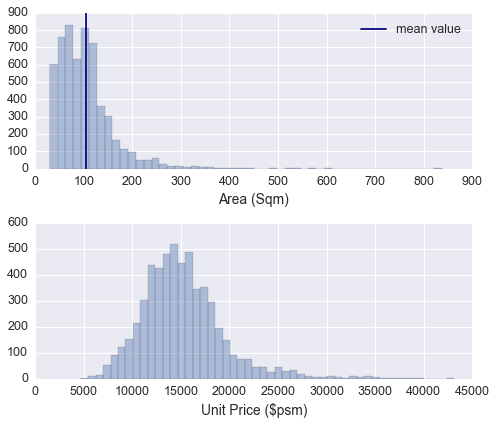

In [16]:
# Distribution of real estate area in square meters and prices per square meter
fig, ax = plt.subplots(2, 1, figsize=(7,6))
sns.distplot(singapore['Area (Sqm)'], kde=False, ax=ax[0])
axmin, axmax = ax[0].get_ylim()
ax[0].vlines(singapore['Area (Sqm)'].mean(), axmin, axmax, colors='navy', linestyles='-', label='mean value')
sns.distplot(singapore['Unit Price ($psm)'], kde=False, ax=ax[1])
ax[0].legend(loc='best')
plt.tight_layout()
plt.show()

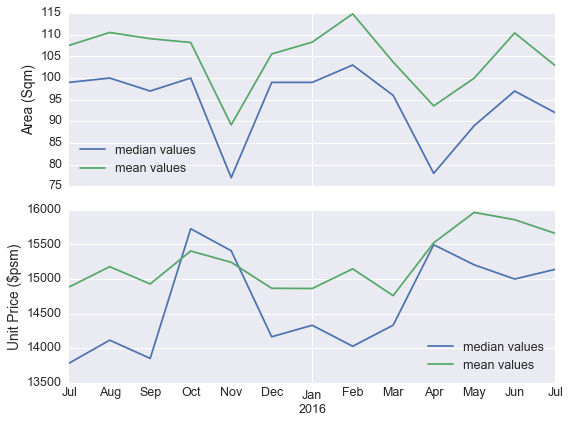

In [17]:
# Changes in unit price and area during year (Jul 2015 - Jul 2016)
median_area = singapore['Area (Sqm)'].resample('1M').median()
mean_area = singapore['Area (Sqm)'].resample('1M').mean()

median_prices = singapore['Unit Price ($psm)'].resample('1M').median()
mean_prices = singapore['Unit Price ($psm)'].resample('1M').mean()

fig, ax = plt.subplots(2, 1, sharex=True,figsize=(8,6))
median_area.plot(ax=ax[0], label='median values')
mean_area.plot(ax=ax[0], label='mean values')
ax[0].set_ylabel('Area (Sqm)')
ax[0].legend(loc='best')
median_prices.plot(ax=ax[1], label='median values')
mean_prices.plot(ax=ax[1], label='mean values')
ax[1].set_ylabel('Unit Price ($psm)')
ax[1].legend(loc='best')
plt.tight_layout()
plt.show()

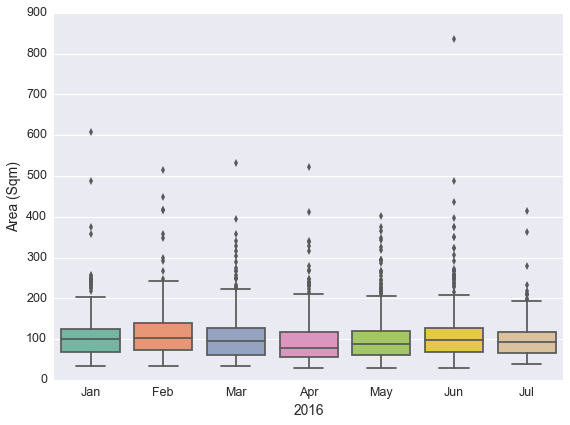

In [18]:
data_months = OrderedDict()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul']
months = singapore['Area (Sqm)'].ix['2016'].groupby(lambda x: x.month)
for name, i in zip(month_names, range(1, 8)):
    data_months[name] = pd.Series(months.get_group(i).values)
data_pd = pd.DataFrame(data_months)

# Seaborn boxplot
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=data_pd, orient='v', palette='Set2', ax=ax)
ax.set_xlabel('2016')
ax.set_ylabel('Area (Sqm)')
plt.tight_layout()
plt.show()

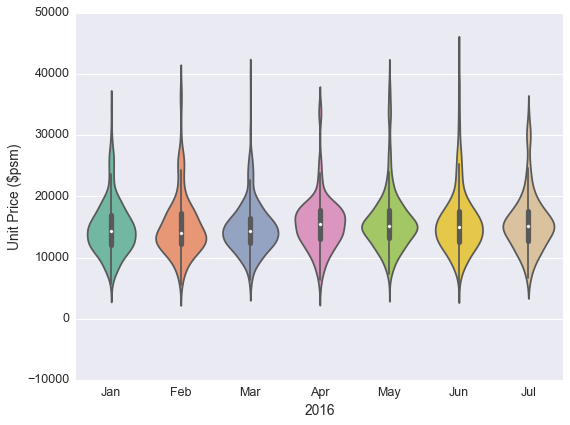

In [19]:
months = singapore['Unit Price ($psm)'].ix['2016'].groupby(lambda x: x.month)
data_months = OrderedDict()
for name, i in zip(month_names, range(1, 8)):
    data_months[name] = pd.Series(months.get_group(i).values)
data_pd = pd.DataFrame(data_months)

# Seaborn boxplot
fig, ax = plt.subplots(figsize=(8,6))
sns.violinplot(data=data_pd, orient='v', palette='Set2', ax=ax)
ax.set_xlabel('2016')
ax.set_ylabel('Unit Price ($psm)')
plt.tight_layout()
plt.show()

In [20]:
# Average unit prices and average square area for each street address
streets = singapore.groupby('Street Name')[['Area (Sqm)', 'Unit Price ($psm)']].mean().reset_index()
streets.describe()

,Area (Sqm),Unit Price ($psm)
count,321.000000,321.000000
mean,124.448099,14422.338075
std,53.313934,4709.489949
min,36.000000,5635.600000
25%,90.200000,11390.181818
50%,114.666667,13550.166667
75%,143.400000,16400.538462
max,376.000000,38900.200000


#### Geocoding address names

In [ ]:
# Geocoding address names
geolocator = Nominatim()
lon = []
lat = []
for street_name in streets['Street Name']:
    try:
        location = geolocator.geocode(street_name + ' SINGAPORE')
        lat.append(location.latitude)
        lon.append(location.longitude)
        time.sleep(0.5)
    except AttributeError:
        print('Address not found: {:s}'.format(street_name))
        lat.append(np.NaN)
        lon.append(np.NaN)
    except GeocoderTimedOut as Geocoder:
        print(Geocoder)
    except ServiceTimedOut as Service:
        print(Service)
    except Exception as E:
        print(E)

In [ ]:
# Pickle geolocations
lon_lat = {'lon':lon, 'lat':lat}
with open('geolocations-all.pkl', 'wb') as file_name:
    pickle.dump(lon_lat, file_name)

In [22]:
# Read pickled geolocations
with open('geolocations-all.pkl', 'rb') as file_name:
    lon_lat = pickle.load(file_name)
lon = lon_lat['lon']
lat = lon_lat['lat']

In [23]:
# Average values for all streets
prices = streets['Unit Price ($psm)']
price_min = prices.min()
price_max = prices.max()
areas = streets['Area (Sqm)']

In [24]:
weights = prices/price_max
hist, bin_edges = np.histogram(weights)

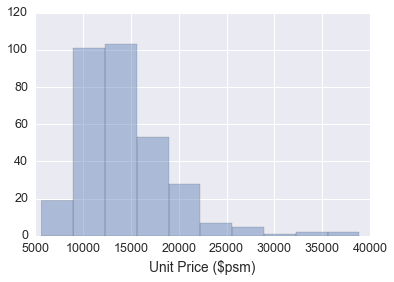

In [25]:
sns.distplot(prices, bins=10, kde=False)

In [26]:
# Define colors for the colorbar
colors = []
for w in bin_edges:
    c = '#%02x%02x%02x' % tuple(map(lambda x: int(x*255), colorsys.hsv_to_rgb(w, 1, 0.5)))
    colors.append(c)

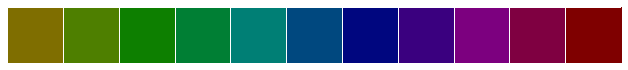

In [27]:
sns.palplot(sns.color_palette(colors))

### MyTransport Singapore

https://www.mytransport.sg/content/mytransport/home.html

In [21]:
# Shapefiles of Metro stations
myshp = open('TrainStation_Nov2015/TrainStations.shp', 'rb')
mydbf = open('TrainStation_Nov2015/TrainStations.dbf', 'rb')
sf = shapefile.Reader(shp=myshp, dbf=mydbf)
records = sf.shapeRecords()

https://github.com/cgcai/SVY21

In [22]:
# Singapore GPS system
from svy21 import SVY21
svy = SVY21()

### Map of Singapore real estates prices

In [30]:
# Folium map (average unit prices and square area of real estates)
mapa = folium.Map(location=[1.33, 103.84], zoom_start=12)
# Metro stations
for rec in records:
    lon_m, lat_m = svy.computeLatLon(rec.shape.points[0][1], rec.shape.points[0][0])
    name = rec.record[0]
    folium.RegularPolygonMarker(location=[lon_m, lat_m], radius=4, 
                                popup='{:s}'.format(name), 
                                fill_color='black', number_of_sides=4).add_to(mapa)
# Real estates with prices
for x, y, p, a, w in zip(lon, lat, prices, areas, weights):
    for k in range(1, len(bin_edges)):
        if bin_edges[k-1] < w < bin_edges[k]:
            c = colors[k]
    if not np.isnan(x) and not np.isnan(y):
        folium.RegularPolygonMarker(location=[y, x], radius=8, 
                                    popup='Area: {:g} (Sqm) \nUnit price {:g} ($psm)'.format(a, p), 
                                    fill_color=c, number_of_sides=12).add_to(mapa)
# Colormap 
color_map = folium.colormap.LinearColormap(colors, vmin=price_min, vmax=price_max, caption='Unit Price ($psm)')
mapa.add_children(color_map)
mapa

In [31]:
# Number of real estates sold at each address
num_sold = singapore.groupby('Street Name')['Project Name'].count()
num_mean = num_sold.mean()
num_sold.describe()

count    321.000000
mean      17.744548
std       46.439108
min        1.000000
25%        2.000000
50%        5.000000
75%       15.000000
max      507.000000
Name: Project Name, dtype: float64

In [32]:
# Folim map for the number of sales at each address
mapa = folium.Map(location=[1.33, 103.84], zoom_start=12)
for x, y, num in zip(lon, lat, num_sold):
    if not np.isnan(x) and not np.isnan(y):
        if num < 100:
            rad = 50*num/num_mean
        else:
            rad = 25*num/num_mean
        folium.CircleMarker(location=[y, x], radius=rad, popup='Units sold: {:d}'.format(num),
                        color='#3186cc', fill_color='#3186cc').add_to(mapa)
mapa

In [33]:
heat_map_data = []
for x, y, z in zip(lat, lon, weights):
    if not np.isnan(x) and not np.isnan(y):
        heat_map_data.append([x, y, z])
# Add small amount of randomness to the lat lon data points for better visualization
heat_map = (np.random.normal(loc=0, scale=0.00001, size=(len(heat_map_data), 3)) *
            np.array([[1, 1, 0]]) +
            np.array(heat_map_data)).tolist()

In [34]:
# Map of real estate transactions activity
mapa = folium.Map(location=[1.33, 103.84], zoom_start=12)
mapa.add_children(plugins.HeatMap(heat_map, radius=15))
mapa

In [35]:
# The most expensive real estate projects in Singapore (per square meter)
ss = singapore.groupby(['Project Name', 'Street Name', 'Area (Sqm)', 
                        'Price ($)'])['Unit Price ($psm)'].max().reset_index()
top = ss.sort_values('Unit Price ($psm)', ascending=False)
top.head(10)

,Project Name,Street Name,Area (Sqm),Price ($),Unit Price ($psm)
2016,LE NOUVEL ARDMORE,ARDMORE PARK,487.0,21000000.0,43121.0
2015,LE NOUVEL ARDMORE,ARDMORE PARK,368.0,15844000.0,43054.0
2228,NASSIM PARK RESIDENCES,NASSIM ROAD,323.0,13500000.0,41796.0
3096,SEVEN PALMS SENTOSA COVE,COVE DRIVE,394.0,15782000.0,40056.0
172,ARDMORE THREE,ARDMORE PARK,162.0,6435350.0,39724.0
2225,NASSIM PARK RESIDENCES,NASSIM ROAD,295.0,11700000.0,39661.0
171,ARDMORE THREE,ARDMORE PARK,162.0,6334710.0,39103.0
186,ARDMORE THREE,ARDMORE PARK,165.0,6406790.0,38829.0
170,ARDMORE THREE,ARDMORE PARK,162.0,6212650.0,38350.0
598,BOULEVARD VUE,CUSCADEN WALK,416.0,15896900.0,38214.0


#### Le Nouvel Ardmore
http://www.lenouvelardmore.sg

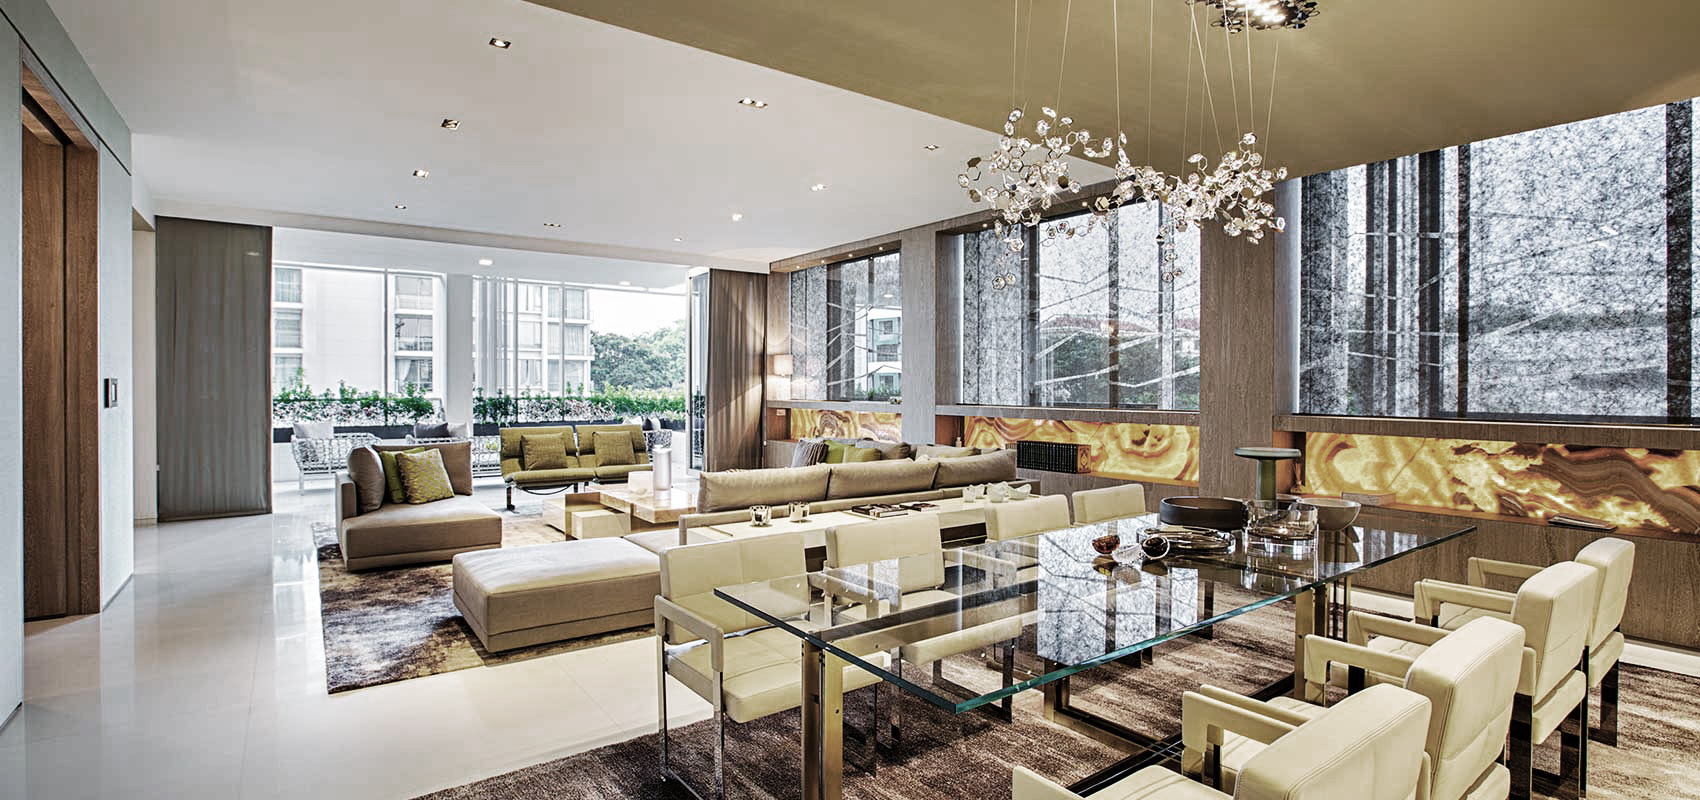

In [36]:
Image(filename='livingroom.jpg', width=600, height=400)

In [37]:
# Most expensive real estates in Singapore by total price paid ($)
ss = singapore.groupby(['Project Name', 'Street Name', 'Area (Sqm)', 
                        'Unit Price ($psm)'])['Price ($)'].max().reset_index()
top_dollars = ss.sort_values('Price ($)', ascending=False).iloc[:10]
top_dollars

,Project Name,Street Name,Area (Sqm),Unit Price ($psm),Price ($)
276,BISHOPSGATE RESIDENCES,BISHOPSGATE,565.0,37296.0,21071994.0
2016,LE NOUVEL ARDMORE,ARDMORE PARK,487.0,43121.0,21000000.0
3975,THE NASSIM,NASSIM HILL,837.0,24194.0,20250000.0
598,BOULEVARD VUE,CUSCADEN WALK,416.0,38214.0,15896900.0
2015,LE NOUVEL ARDMORE,ARDMORE PARK,368.0,43054.0,15844000.0
3087,SEVEN PALMS SENTOSA COVE,COVE DRIVE,394.0,40056.0,15782000.0
597,BOULEVARD VUE,CUSCADEN WALK,416.0,36599.0,15225200.0
3208,ST REGIS RESIDENCES SINGAPORE,TANGLIN ROAD,515.0,29126.0,15000000.0
596,BOULEVARD VUE,CUSCADEN WALK,416.0,35307.0,14687840.0
3974,THE NASSIM,NASSIM HILL,397.0,34594.0,13734000.0


In [38]:
# Geocoding address names (top ten real estates)
geolocator = Nominatim()
lon_top = []
lat_top = []
for street_name in top_dollars['Street Name'].iloc[:10]:
    try:
        location = geolocator.geocode(street_name + ' SINGAPORE')
        lat_top.append(location.latitude)
        lon_top.append(location.longitude)
        time.sleep(1)
    except AttributeError:
        print('Address not found: {:s}'.format(street_name))
        lat_top.append(np.NaN)
        lon_top.append(np.NaN)
    except GeocoderTimedOut as Geocoder:
        print(Geocoder)
    except ServiceTimedOut as Service:
        print(Service)
    except Exception as E:
        print(E)

In [39]:
print(top_dollars['Street Name'].iloc[:10].unique())

['BISHOPSGATE' 'ARDMORE PARK' 'NASSIM HILL' 'CUSCADEN WALK' 'COVE DRIVE'
 'TANGLIN ROAD']


In [40]:
top_dollars['lon'] = lon_top
top_dollars['lat'] = lat_top

### Top ten real estates sold in the last year in Singapore (in actual $ value)

In [41]:
top_address = top_dollars.groupby('Street Name')['Price ($)'].max().reset_index()
top_address

,Street Name,Price ($)
0,ARDMORE PARK,21000000.0
1,BISHOPSGATE,21071994.0
2,COVE DRIVE,15782000.0
3,CUSCADEN WALK,15896900.0
4,NASSIM HILL,20250000.0
5,TANGLIN ROAD,15000000.0


In [42]:
# Folium map (top ten real estate addresses)
mapa = folium.Map(location=[1.28, 103.85], zoom_start=13)
for x, y, a, p in zip(lon_top, lat_top, top_dollars['Street Name'].iloc[:10], top_dollars['Price ($)'].iloc[:10]):
    folium.RegularPolygonMarker(location=[y, x], radius=8, 
                                popup='{:s}'.format(a), 
                                fill_color='red', number_of_sides=12).add_to(mapa)
mapa

### Map of Singapore realestate prices for July 2016

In [ ]:
# Geocoding address names for 2016-07
geolocator = Nominatim()
lon = []
lat = []
for street_name in singapore['Street Name'].ix['2016-07']:
    try:
        location = geolocator.geocode(street_name + ' SINGAPORE')
        lat.append(location.latitude)
        lon.append(location.longitude)
        time.sleep(0.5)
    except AttributeError:
        print('Address not found: {:s}'.format(street_name))
        lat.append(np.NaN)
        lon.append(np.NaN)
    except GeocoderTimedOut as Geocoder:
        print(Geocoder)
    except ServiceTimedOut as Service:
        print(Service)
    except Exception as E:
        print(E)

In [ ]:
# Pickle geolocations
lon_lat = {'lon':lon, 'lat':lat}
with open('geolocations-july.pkl', 'wb') as file_name:
    pickle.dump(lon_lat, file_name)

In [23]:
with open('geolocations-july.pkl', 'rb') as file_name:
    lon_lat = pickle.load(file_name)
lon = lon_lat['lon']
lat = lon_lat['lat']

In [24]:
# Values for July-2016
prices = singapore['Unit Price ($psm)'].ix['2016-07']
price_min = singapore['Unit Price ($psm)'].ix['2016-07'].min()
price_max = singapore['Unit Price ($psm)'].ix['2016-07'].max()
areas = singapore['Area (Sqm)'].ix['2016-07']

In [25]:
weights = prices/price_max
hist, bin_edges = np.histogram(weights)

In [26]:
# Define colors for the colorbar
colors = []
for w in bin_edges:
    c = '#%02x%02x%02x' % tuple(map(lambda x: int(x*255), colorsys.hsv_to_rgb(w, 1, 0.5)))
    colors.append(c)

In [27]:
# Folium map (prices for July-2016)
mapa = folium.Map(location=[1.33, 103.84], zoom_start=12)
# Metro stations
for rec in records:
    lon_m, lat_m = svy.computeLatLon(rec.shape.points[0][1], rec.shape.points[0][0])
    name = rec.record[0]
    folium.RegularPolygonMarker(location=[lon_m, lat_m], radius=4, 
                                popup='{:s}'.format(name), 
                                fill_color='black', number_of_sides=4).add_to(mapa)
# Real estates with prices
for x, y, p, a, w in zip(lon, lat, prices, areas, weights):
    for k in range(1, len(bin_edges)):
        if bin_edges[k-1] < w < bin_edges[k]:
            c = colors[k]
    if x is not np.NaN and y is not np.NaN:
        folium.RegularPolygonMarker(location=[y, x], radius=8, 
                                    popup='Area: {:g} (Sqm) \nUnit price {:g} ($psm)'.format(a, p), 
                                    fill_color=c, number_of_sides=12).add_to(mapa)
# Colormap 
color_map_july = folium.colormap.LinearColormap(colors, vmin=price_min, vmax=price_max, 
                                                caption='Unit Price ($psm)')
mapa.add_children(color_map_july)
mapa

In [28]:
# Create new pandas DataFrame for the July-2016
july = pd.DataFrame({'unit_price':prices, 'area':areas}, index=prices.index)
july['floor'] = singapore['Floor Level'].ix['2016-07']
july['address'] = singapore['Street Name'].ix['2016-07']
july['project'] = singapore['Project Name'].ix['2016-07']
july['lon'] = lon
july['lat'] = lat
july.head()

,area,unit_price,floor,address,project,lon,lat
2016-07-01,45.0,21556.0,21 to 25,TELOK BLANGAH ROAD,SKYLINE RESIDENCES,103.829223,1.269607
2016-07-01,191.0,11754.0,01 to 05,DEPOT ROAD,THE INTERLACE,103.817524,1.279995
2016-07-01,98.0,11531.0,01 to 05,WEST COAST ROAD,CLEMENTIWOODS CONDOMINIUM,103.748170,1.317958
2016-07-01,50.0,16620.0,21 to 25,JALAN LEMPENG,THE TRILINQ,103.760285,1.318960
2016-07-01,85.0,15224.0,16 to 20,JALAN LEMPENG,THE TRILINQ,103.760285,1.318960


### Real estates sold in July 2016 within 1000 m distance from the select metro station

In [49]:
# Real estates within certain distance from the select metro station
distance_max = 1100.  # meters
station_name = 'Bartley'

distance = []
for rec in records:
    if rec.record[0].title() == station_name:
        print('Found: {:s}'.format(station_name))
        lat_m, lon_m = svy.computeLatLon(rec.shape.points[0][1], rec.shape.points[0][0])
        metro = (lat_m, lon_m)
        for lon_h, lat_h in zip(july['lon'], july['lat']):
            house = (lat_h, lon_h)
            dist = great_circle(metro, house).meters
            if dist <= distance_max:
                distance.append(dist)
            else:
                distance.append(np.NaN)

Found: Bartley


In [50]:
july['distance'] = distance
july_station = july.dropna()
july_station

,area,unit_price,floor,address,project,lon,lat,distance
2016-07-01,115.0,10957.0,06 to 10,JALAN BUNGA RAMPAI,OASIS GARDEN,103.883811,1.339922,558.780133
2016-07-01,96.0,14688.0,11 to 15,UPPER PAYA LEBAR ROAD,BOTANIQUE AT BARTLEY,103.884993,1.340715,631.907119
2016-07-01,61.0,14459.0,16 to 20,UPPER PAYA LEBAR ROAD,BOTANIQUE AT BARTLEY,103.884993,1.340715,631.907119
2016-07-01,91.0,10275.0,01 to 05,HOUGANG STREET 11,THE MINTON,103.879506,1.352260,1047.370281
2016-07-01,61.0,14443.0,11 to 15,UPPER PAYA LEBAR ROAD,BOTANIQUE AT BARTLEY,103.884993,1.340715,631.907119
2016-07-01,69.0,13304.0,01 to 05,SOMMERVILLE WALK,R MAISON,103.870012,1.344448,1094.622176
2016-07-01,61.0,14230.0,11 to 15,UPPER PAYA LEBAR ROAD,BOTANIQUE AT BARTLEY,103.884993,1.340715,631.907119
2016-07-01,50.0,16723.0,01 to 05,BARTLEY ROAD,THE QUINN,103.882501,1.341475,344.314520
2016-07-01,61.0,14590.0,16 to 20,UPPER PAYA LEBAR ROAD,BOTANIQUE AT BARTLEY,103.884993,1.340715,631.907119
2016-07-01,52.0,17167.0,01 to 05,BARTLEY ROAD,THE QUINN,103.882501,1.341475,344.314520


In [51]:
print(july_station['project'].unique())

['OASIS GARDEN' 'BOTANIQUE AT BARTLEY' 'THE MINTON' 'R MAISON' 'THE QUINN'
 'TANGERINE GROVE']


In [52]:
july_station['unit_price'].describe()

count       14.000000
mean     14148.000000
std       1965.830339
min      10275.000000
25%      13371.500000
50%      14410.000000
75%      14663.500000
max      17167.000000
Name: unit_price, dtype: float64

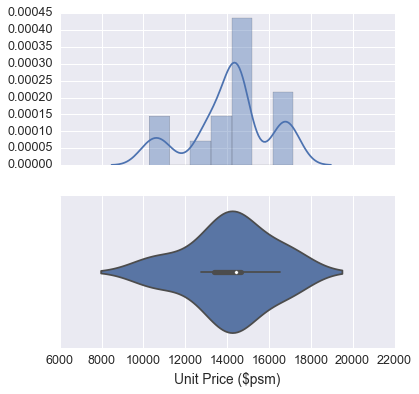

In [53]:
# Distribution of unit prices of real estates within the
# select distance from the metro station under consideration
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(6,6))
sns.distplot(july_station['unit_price'], ax=ax[0])
sns.violinplot(july_station['unit_price'], ax=ax[1])
ax[0].set_xlabel('')
ax[1].set_xlabel('Unit Price ($psm)')

In [54]:
# Average area and average unit price per project for July 2016
projects = july_station.groupby('project')[['area', 'unit_price', 'lat', 'lon']].mean().reset_index()
projects

,project,area,unit_price,lat,lon
0,BOTANIQUE AT BARTLEY,66.0,14337.285714,1.340715,103.884993
1,OASIS GARDEN,115.0,10957.000000,1.339922,103.883811
2,R MAISON,69.0,13304.000000,1.344448,103.870012
3,TANGERINE GROVE,85.0,12765.000000,1.347547,103.882851
4,THE MINTON,91.0,10275.000000,1.352260,103.879506
5,THE QUINN,67.0,16803.333333,1.341475,103.882501


In [55]:
# Folium map with average prices of real estates within select distance from the metro station
mapa = folium.Map(location=[1.35, 103.87], zoom_start=14)
folium.Marker(location=metro, popup=station_name, icon=folium.Icon(icon='info-sign')).add_to(mapa)
folium.CircleMarker(location=metro, radius=distance_max, popup='{:s}'.format(station_name),
                        color='#ffffcc', fill_color='#ffffcc').add_to(mapa)
for lon_h, lat_h, name, price in zip(projects['lat'], projects['lon'], 
                                     projects['project'], projects['unit_price']):
    folium.RegularPolygonMarker(location=[lon_h, lat_h], radius=8, 
                                popup='{:s} Unit price: {:g} ($psm)'.format(name,price), 
                                fill_color='red', number_of_sides=12).add_to(mapa)
mapa

In [56]:
# Real estates with unit prices below the mean price and with the square area of over 80 Sqm
july_station[(july_station['unit_price']<july_station['unit_price'].mean()) & (july_station['area']>80.)]

,area,unit_price,floor,address,project,lon,lat,distance
2016-07-01,115.0,10957.0,06 to 10,JALAN BUNGA RAMPAI,OASIS GARDEN,103.883811,1.339922,558.780133
2016-07-01,91.0,10275.0,01 to 05,HOUGANG STREET 11,THE MINTON,103.879506,1.352260,1047.370281
2016-07-01,85.0,12765.0,01 to 05,PAYA LEBAR CRESCENT,TANGERINE GROVE,103.882851,1.347547,627.875838


### The Minton Residences

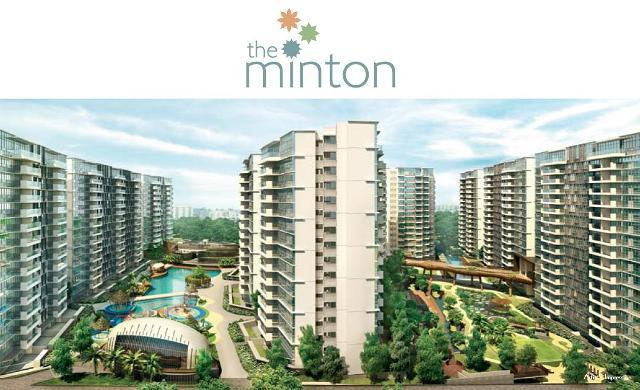

In [57]:
Image(filename='minton_sg.jpg', width=600, height=400)

In [58]:
# The Minton real estate sales within the last year
minton = singapore[singapore['Project Name']=='THE MINTON']
minton[['Price ($)', 'Area (Sqm)', 'Unit Price ($psm)']].describe()

,Price ($),Area (Sqm),Unit Price ($psm)
count,2.400000e+01,24.000000,24.0000
mean,1.082833e+06,96.333333,11245.6250
std,2.565525e+05,20.975486,899.1625
min,6.600000e+05,51.000000,9459.0000
25%,9.522500e+05,91.000000,10647.2500
50%,1.062500e+06,97.000000,11064.0000
75%,1.291250e+06,113.000000,11902.5000
max,1.480000e+06,135.000000,12941.0000


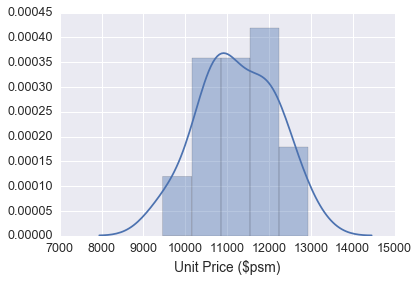

In [59]:
# Distribution of unit prices for The Minton
sns.distplot(minton['Unit Price ($psm)'])

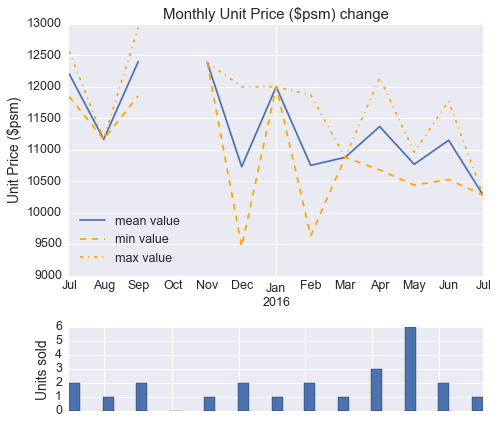

In [60]:
# Time evolution of the Unit Price ($psm) for The Minton residences
minton = singapore[singapore['Project Name']=='THE MINTON'].resample('1M').mean()
minton_min = singapore[singapore['Project Name']=='THE MINTON'].resample('1M').min()
minton_max = singapore[singapore['Project Name']=='THE MINTON'].resample('1M').max()
minton_count = singapore[singapore['Project Name']=='THE MINTON'].resample('1M').count()
fig = plt.figure(1, figsize=(7,6))
grid = gs.GridSpec(2, 1, height_ratios=[3,1])
ax1 = plt.subplot(grid[0,0])
ax2 = plt.subplot(grid[1,0])
minton['Unit Price ($psm)'].plot(ls='-', label='mean value', ax=ax1)
minton_min['Unit Price ($psm)'].plot(ls='--', c='orange', label='min value', ax=ax1)
minton_max['Unit Price ($psm)'].plot(ls='-.', c='orange', label='max value', ax=ax1)
ax1.set_title('Monthly Unit Price ($psm) change')
ax1.set_ylabel('Unit Price ($psm)')
ax1.legend(loc='lower left')
ax2.bar(minton_count.index, minton_count['No. of Units'], width=10)
ax2.set_ylabel('Units sold')
ax2.set_xticklabels('')
plt.tight_layout()
plt.show()

In [61]:
singapore[singapore['Project Name']=='THE MINTON'].ix['2016-02']

,Project Name,Street Name,Type,Postal District,Market Segment,Tenure,Type of Sale,No. of Units,Price ($),Area (Sqm),Type of Area,Floor Level,Unit Price ($psm)
2016-02-01,THE MINTON,HOUGANG STREET 11,Condominium,19.0,OCR,99 yrs lease commencing from 2007,Resale,1.0,1460000.0,123.0,Strata,01 to 05,11870.0
2016-02-01,THE MINTON,HOUGANG STREET 11,Condominium,19.0,OCR,99 yrs lease commencing from 2007,Resale,1.0,1050000.0,109.0,Strata,01 to 05,9633.0


In [62]:
# Real estate deals in "The Minton" residences
# Real estates above the fifth floor with unit prices below the cheapest 5% of the neighborhood
# Unit prices of the neighborhood are for the July 2016
minton = singapore[singapore['Project Name']=='THE MINTON']
minton[(minton['Unit Price ($psm)'] < july_station['unit_price'].quantile(0.05)) & 
       (minton['Floor Level'].values != '01 to 05')]

,Project Name,Street Name,Type,Postal District,Market Segment,Tenure,Type of Sale,No. of Units,Price ($),Area (Sqm),Type of Area,Floor Level,Unit Price ($psm)
2016-05-01,THE MINTON,HOUGANG STREET 11,Condominium,19.0,OCR,99 yrs lease commencing from 2007,Resale,1.0,960000.0,91.0,Strata,11 to 15,10549.0
2016-04-01,THE MINTON,HOUGANG STREET 11,Condominium,19.0,OCR,99 yrs lease commencing from 2007,Resale,1.0,1100000.0,103.0,Strata,06 to 10,10680.0


## Pricing real estates using Machine Learning

### Encoding dataset features

In [10]:
# Encode: Market Segment
le_ms = preprocessing.LabelEncoder()
le_ms.fit(['OCR', 'RCR', 'CCR'])
ms_transf = le_ms.transform(singapore['Market Segment'])
# Encode: Floor Level
floors = list(singapore['Floor Level'].unique())
floors.sort()
le_level = preprocessing.LabelEncoder()
le_level.fit(floors)
floor_transf = le_level.transform(singapore['Floor Level'])
# Encode: Project name
project = list(singapore['Project Name'].unique())
project.sort()
le_project = preprocessing.LabelEncoder()
le_project.fit(project)
project_transf = le_project.transform(singapore['Project Name'])
# Encode: Street name
street = list(singapore['Street Name'].unique())
street.sort()
le_street = preprocessing.LabelEncoder()
le_street.fit(street)
street_transf = le_street.transform(singapore['Street Name'])
# Encode: Type of Sale
sale = list(singapore['Type of Sale'].unique())
sale.sort()
le_sale = preprocessing.LabelEncoder()
le_sale.fit(sale)
sale_transf = le_sale.transform(singapore['Type of Sale'])

In [11]:
# Assemble features into a DataFrame
sing = singapore[['Postal District', 'Area (Sqm)']].copy()
sing['Market Segment'] = ms_transf
sing['Floor Level'] = floor_transf
sing['Project Name'] = project_transf
sing['Street Name'] = street_transf
sing['Type of Sale'] = sale_transf
sing.head()

,Postal District,Area (Sqm),Market Segment,Floor Level,Project Name,Street Name,Type of Sale
2016-07-01,4.0,45.0,2,5,461,287,1
2016-07-01,4.0,191.0,2,1,567,48,1
2016-07-01,5.0,98.0,1,1,101,305,1
2016-07-01,5.0,50.0,1,5,629,107,0
2016-07-01,5.0,85.0,1,4,629,107,0


In [12]:
y = singapore['Unit Price ($psm)'].copy()
y.head()

2016-07-01    21556.0
2016-07-01    11754.0
2016-07-01    11531.0
2016-07-01    16620.0
2016-07-01    15224.0
Name: Unit Price ($psm), dtype: float64

In [13]:
# Predictivity
pearson = sing.corr('pearson')
pearson.ix[-1][:-1].sort_values()

Market Segment    -0.167030
Street Name       -0.105626
Project Name      -0.101161
Floor Level       -0.082052
Postal District    0.020442
Area (Sqm)         0.349203
Name: Type of Sale, dtype: float64

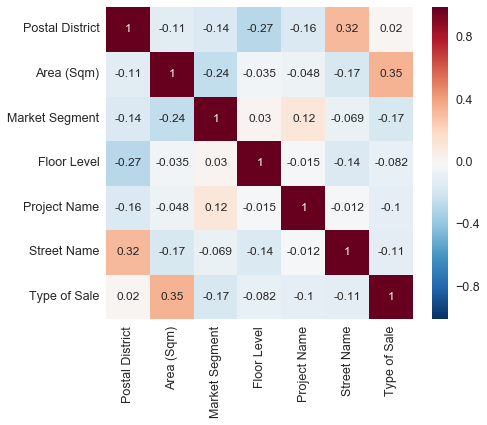

In [14]:
# Correlation matrix as heatmap (seaborn)
fig, ax = plt.subplots(figsize=(7,6))
sns.heatmap(pearson, annot=True, annot_kws=dict(size=12), vmin=-1, vmax=1, ax=ax)
plt.tight_layout()
plt.show()

### Train test data split

In [15]:
# Split data into train and test leaving last ten (10) rows for the final evaluation
X_train, X_test, y_train, y_test = train_test_split(sing.iloc[:-10], y.iloc[:-10], test_size=0.2)

In [16]:
print('Database size: {:g} \nTrain set size: {:g} \nTest set size: {:g} \nValidate set size: {:g}'
      .format(len(singapore), len(y_train), len(y_test), len(singapore)-(len(y_train)+len(y_test))))

Database size: 5696 
Train set size: 4548 
Test set size: 1138 
Validate set size: 10


In [17]:
# Scale data
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
# Train & evaluate model performance
def train_and_evaluate(model, X, y):
    model.fit(X, y)
    print('Score on training set: {:g}'.format(model.score(X, y)))
    # k-fold cross validation iterator of 5 folds
    cv = KFold(X.shape[0], 5, shuffle=True)
    scores = cross_val_score(model, X, y, cv=cv)
    print('Score using 5-fold cross-validation: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)*2))

### Ordinary least squares Linear Regression

In [19]:
# Ordinary least squares Linear Regression
clf_lr = linear_model.LinearRegression()
train_and_evaluate(clf_lr, X_train, y_train.ravel())

Score on training set: 0.345029
Score using 5-fold cross-validation: 0.339421 +/- 0.0114021


In [20]:
# Test model prediction on test data
y_pred = clf_lr.predict(X_test)
print('R2 score: {:g}'.format(metrics.r2_score(y_test, y_pred)))
print('Explained variance score: {:g}'.format(metrics.explained_variance_score(y_test, y_pred)))
print('Mean squared error: {:g}'.format(metrics.mean_squared_error(y_test, y_pred)))

R2 score: 0.31466
Explained variance score: 0.315557
Mean squared error: 1.26115e+07


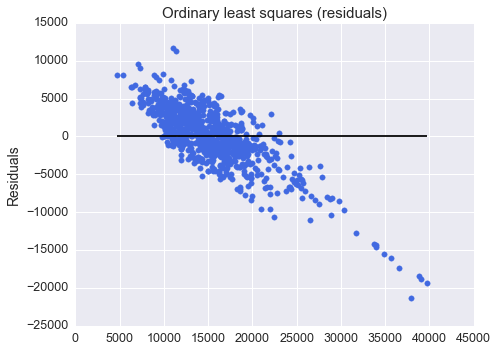

In [21]:
# Residual plot
fig, ax = plt.subplots(figsize=(7,5))
ax.set_title('Ordinary least squares (residuals)')
ax.scatter(y_test, y_pred-y_test, color='royalblue', s=30)
ax.set_ylabel('Residuals')
ax.hlines(0, y_test.min(), y_test.max())
plt.tight_layout()
plt.show()

### Polynomial regression

In [22]:
model = make_pipeline(preprocessing.PolynomialFeatures(degree=3), linear_model.Ridge())
train_and_evaluate(model, X_train, y_train.ravel())

Score on training set: 0.723394
Score using 5-fold cross-validation: 0.674283 +/- 0.069613


In [23]:
# Test model prediction on test data
y_pred = model.predict(X_test)
print('R2 score: {:g}'.format(metrics.r2_score(y_test, y_pred)))
print('Explained variance score: {:g}'.format(metrics.explained_variance_score(y_test, y_pred)))
print('Mean squared error: {:g}'.format(metrics.mean_squared_error(y_test, y_pred)))

R2 score: 0.706802
Explained variance score: 0.707004
Mean squared error: 5.39539e+06


### Support Vector Machine with Grid search & Cross-validation

In [24]:
# Support Vector Regression
svr = SVR()
params = {'C':[0.01, 0.1, 1., 10., 100., 1000.],
          'kernel':['linear', 'poly', 'rbf'],
          'epsilon':[0.1, 1.]}
# Grid search with cross-validation for optimal parameters
mach = GridSearchCV(estimator=svr, param_grid=params, cv=5, n_jobs=-1)
mach.fit(X_train, y_train.ravel())
# Test model prediction on test data
y_pred = mach.predict(X_test)
print('R2 score: {:g}'.format(metrics.r2_score(y_test, y_pred)))
print('Explained variance score: {:g}'.format(metrics.explained_variance_score(y_test, y_pred)))
print('Mean squared error: {:g}'.format(metrics.mean_squared_error(y_test, y_pred)))

R2 score: 0.711567
Explained variance score: 0.711934
Mean squared error: 5.30769e+06


### Decision Tree Regressor

In [25]:
# DecisionTreeRegressor
tree = DecisionTreeRegressor()
train_and_evaluate(tree, X_train, y_train.ravel())

Score on training set: 0.995703
Score using 5-fold cross-validation: 0.796397 +/- 0.0667671


In [26]:
# Test model prediction on test data
y_pred = tree.predict(X_test)
print('R2 score: {:g}'.format(metrics.r2_score(y_test, y_pred)))
print('Explained variance score: {:g}'.format(metrics.explained_variance_score(y_test, y_pred)))
print('Mean squared error: {:g}'.format(metrics.mean_squared_error(y_test, y_pred)))

R2 score: 0.832517
Explained variance score: 0.833016
Mean squared error: 3.08199e+06


### Random Forest Regressor

In [27]:
# RandomForrestRegressor
forrest = RandomForestRegressor()
train_and_evaluate(forrest, X_train, y_train.ravel())

Score on training set: 0.972681
Score using 5-fold cross-validation: 0.854924 +/- 0.0290845


In [28]:
# Test model prediction on test data
y_pred = forrest.predict(X_test)
print('R2 score: {:g}'.format(metrics.r2_score(y_test, y_pred)))
print('Explained variance score: {:g}'.format(metrics.explained_variance_score(y_test, y_pred)))
print('Mean squared error: {:g}'.format(metrics.mean_squared_error(y_test, y_pred)))

R2 score: 0.884179
Explained variance score: 0.885072
Mean squared error: 2.13133e+06


### Extremely Randomised Trees Regressor

In [29]:
# Random Forests (Extra Trees)
clf_et = ExtraTreesRegressor()
train_and_evaluate(clf_et, X_train, y_train.ravel())

Score on training set: 0.995703
Score using 5-fold cross-validation: 0.869513 +/- 0.0388613


In [30]:
# Test model prediction on test data
y_pred = clf_et.predict(X_test)
print('R2 score: {:g}'.format(metrics.r2_score(y_test, y_pred)))
print('Explained variance score: {:g}'.format(metrics.explained_variance_score(y_test, y_pred)))
print('Mean squared error: {:g}'.format(metrics.mean_squared_error(y_test, y_pred)))

R2 score: 0.896301
Explained variance score: 0.89722
Mean squared error: 1.90825e+06


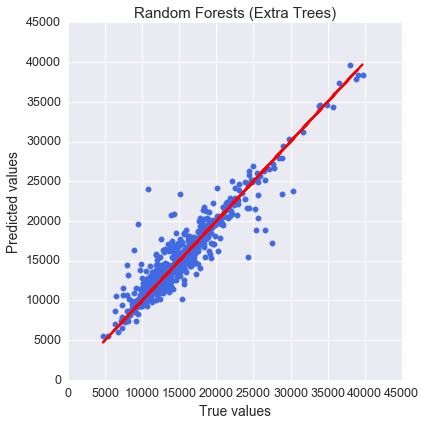

In [31]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_title('Random Forests (Extra Trees)')
ax.scatter(y_test, y_pred, s=30, color='royalblue')
ax.plot(y_test, y_test, c='red', ls='-', lw=2)
ax.set_xlabel('True values')
ax.set_ylabel('Predicted values')
plt.tight_layout()
plt.show()

### AdaBoost Regressor

In [32]:
# AdaBoost Regressor with DecisionTree
clf_ad = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10), n_estimators=100)
train_and_evaluate(clf_ad, X_train, y_train.ravel())

Score on training set: 0.967033
Score using 5-fold cross-validation: 0.863353 +/- 0.0799482


In [33]:
# Test model prediction on test data
y_pred = clf_ad.predict(X_test)
print('R2 score: {:g}'.format(metrics.r2_score(y_test, y_pred)))
print('Explained variance score: {:g}'.format(metrics.explained_variance_score(y_test, y_pred)))
print('Mean squared error: {:g}'.format(metrics.mean_squared_error(y_test, y_pred)))

R2 score: 0.883192
Explained variance score: 0.883998
Mean squared error: 2.14948e+06


### Gradient Boosting Regressor

In [34]:
# Gradient Boosting Regressor
clf_gb = GradientBoostingRegressor(loss='lad', max_depth=10, n_estimators=100)
train_and_evaluate(clf_gb, X_train, y_train.ravel())

Score on training set: 0.967211
Score using 5-fold cross-validation: 0.866702 +/- 0.0423111


In [35]:
# Test model prediction on test data
y_pred = clf_gb.predict(X_test)
print('R2 score: {:g}'.format(metrics.r2_score(y_test, y_pred)))
print('Explained variance score: {:g}'.format(metrics.explained_variance_score(y_test, y_pred)))
print('Mean squared error: {:g}'.format(metrics.mean_squared_error(y_test, y_pred)))

R2 score: 0.891102
Explained variance score: 0.891284
Mean squared error: 2.00393e+06


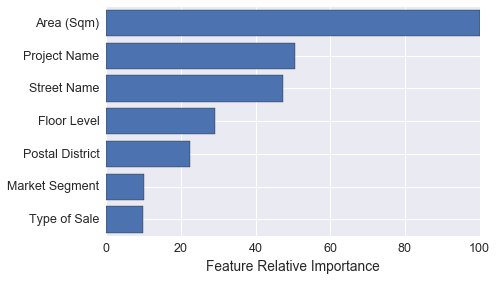

In [36]:
# Feature importance
feature_importance = clf_gb.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig, ax = plt.subplots(figsize=(7,4))
ax.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, sing.columns[sorted_idx])
ax.set_xlabel('Feature Relative Importance')
plt.tight_layout()
plt.show()

### TensorFlow Regression using Deep Neural Network

In [37]:
# TensorFlow Regression using DNN
features = learn.infer_real_valued_columns_from_input(X_train)

# Optimizer algorithm
adam = tf.train.AdamOptimizer(learning_rate=0.001)

# Build a multi-layer DNN for regression
model_nn = learn.DNNRegressor(feature_columns=features, hidden_units=[400, 200, 100], 
                              optimizer=adam, activation_fn=tf.nn.relu,
                              config=learn.estimators.RunConfig(num_cores=8))

# Fit and predict
model_nn.fit(X_train, y_train, steps=15000, batch_size=512)
y_pred = model_nn.predict(X_test)

print('R2 score: {:g}'.format(metrics.r2_score(y_test, y_pred)))
print('Explained variance score: {:g}'.format(metrics.explained_variance_score(y_test, y_pred)))
print('Mean squared error: {:g}'.format(metrics.mean_squared_error(y_test, y_pred)))

R2 score: 0.83431
Explained variance score: 0.836418
Mean squared error: 3.049e+06


### Stacking Multiple Regressors

In [38]:
y_lr = clf_lr.predict(X_test)    # Linear 
y_po = model.predict(X_test)     # Polinomial
y_vm = mach.predict(X_test)      # Support Vector Machine
y_tr = tree.predict(X_test)      # DecisionTree
y_rf = forrest.predict(X_test)   # Random Forrest
y_gb = clf_gb.predict(X_test)    # Gradient Boosting
y_ad = clf_ad.predict(X_test)    # AdaBoost
y_nn = model_nn.predict(X_test)  # DNN
stack = pd.DataFrame(data={'lr':y_lr, 'po':y_po, 'vm':y_vm, 'tr':y_tr, 'rf':y_rf, 
                           'gb':y_gb, 'ad':y_ad, 'nn':y_nn, 'true':y_test})

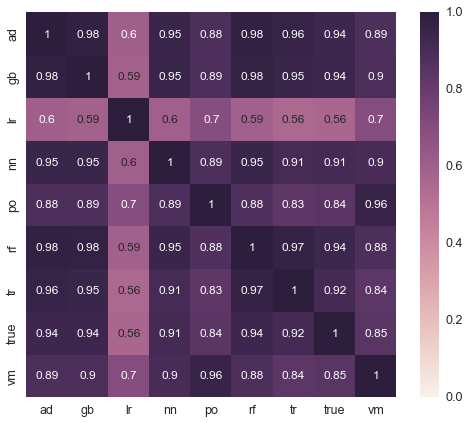

In [39]:
pearson_models = stack.corr('pearson')
# Correlation matrix as heatmap (seaborn)
fig, ax = plt.subplots(figsize=(7,6))
sns.heatmap(pearson_models, annot=True, annot_kws=dict(size=12), vmin=0, vmax=1, ax=ax)
plt.tight_layout()
plt.show()

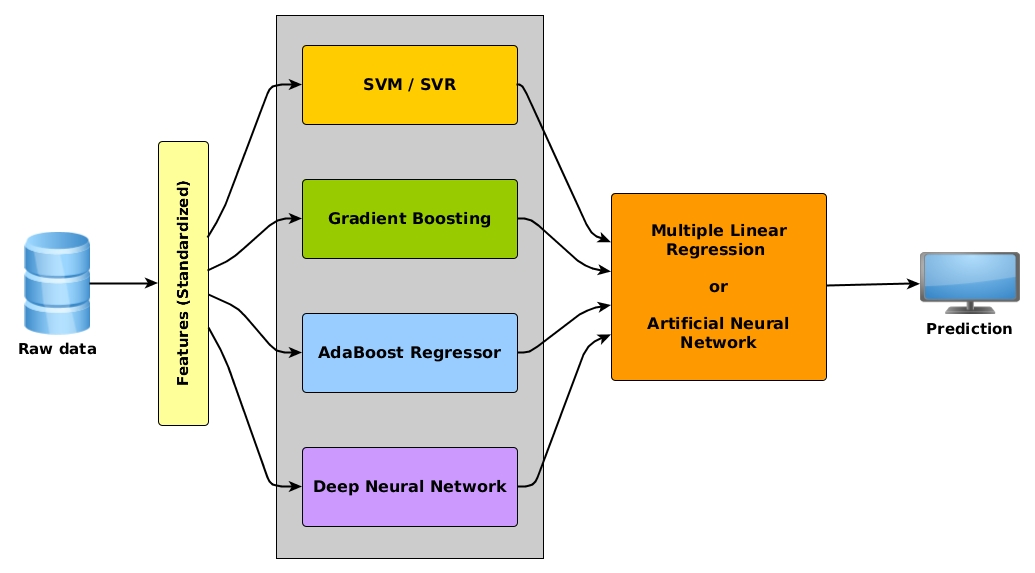

In [40]:
# SVR + Gradient Boosting + AdaBoost + DNN
Image(filename='graph.jpg', width=600, height=400)

In [41]:
# Stacking & Ensembling multiple regressors
stack_type = 'TheilSan'

if stack_type == 'OLS':
    # Ordinary least squares Linear Regression (OLS)
    stacker = linear_model.LinearRegression(fit_intercept=False)
elif stack_type == 'Ridge':
    # Linear least squares with L2 regularization (Ridge)
    stacker = linear_model.Ridge(fit_intercept=False)
elif stack_type == 'TheilSan':
    # Theil-Sen Estimator: robust multivariate regression model
    stacker = linear_model.TheilSenRegressor(fit_intercept=False, n_jobs=-1)

# SVM + Gradient Boosting + AdaBoost + DNN
stacker.fit(X=stack[['vm', 'gb', 'ad', 'nn']], y=stack['true'])

TheilSenRegressor(copy_X=True, fit_intercept=False, max_iter=300,
         max_subpopulation=10000, n_jobs=-1, n_subsamples=None,
         random_state=None, tol=0.001, verbose=False)

In [42]:
# Stacking multiple regressors using DNN
features_blend = learn.infer_real_valued_columns_from_input(stack[['vm', 'gb', 'ad', 'nn']])
# Optimizer algorithm
adam = tf.train.AdamOptimizer(learning_rate=0.001)
# Build multi-layer DNN for regression
blend_nn = learn.DNNRegressor(feature_columns=features_blend, hidden_units=[20, 10], 
                              optimizer=adam, activation_fn=tf.nn.relu,
                              config=learn.estimators.RunConfig(num_cores=8))
# Fit DNN
blend_nn.fit(x=stack[['vm', 'gb', 'ad', 'nn']], y=stack['true'], steps=8000, batch_size=256)

DNNRegressor(hidden_units=[20, 10], dropout=None, optimizer=<tensorflow.python.training.adam.AdamOptimizer object at 0x7f25c76da8d0>, feature_columns=[_RealValuedColumn(column_name='', dimension=4, default_value=None, dtype=tf.float32)])

### Predict prices for unseen real estates

In [43]:
singapore.tail(10)

,Project Name,Street Name,Type,Postal District,Market Segment,Tenure,Type of Sale,No. of Units,Price ($),Area (Sqm),Type of Area,Floor Level,Unit Price ($psm)
2015-07-01,THE TEMBUSU,TAMPINES ROAD,Condominium,19.0,OCR,Freehold,New Sale,1.0,1890000.0,127.0,Strata,01 to 05,14882.0
2015-07-01,JEWEL @ BUANGKOK,COMPASSVALE BOW,Condominium,19.0,OCR,99 years leasehold,New Sale,1.0,1403250.0,106.0,Strata,11 to 15,13238.0
2015-07-01,OASIS GARDEN,JALAN BUNGA RAMPAI,Condominium,19.0,RCR,Freehold,Resale,1.0,1438000.0,114.0,Strata,11 to 15,12614.0
2015-07-01,KENSINGTON PARK CONDOMINIUM,KENSINGTON PARK DRIVE,Condominium,19.0,OCR,999 yrs lease commencing from 1878,Resale,1.0,1700000.0,155.0,Strata,11 to 15,10968.0
2015-07-01,THE MAKENA,MEYER ROAD,Condominium,15.0,RCR,Freehold,Resale,1.0,1470000.0,107.0,Strata,11 to 15,13738.0
2015-07-01,CHUAN PARK,LORONG CHUAN,Condominium,19.0,OCR,99 yrs lease commencing from 1980,Resale,1.0,1600000.0,172.0,Strata,01 to 05,9302.0
2015-07-01,THE SEA VIEW,AMBER ROAD,Condominium,15.0,RCR,Freehold,Resale,1.0,2450000.0,153.0,Strata,11 to 15,16013.0
2015-07-01,THE ESTA,AMBER GARDENS,Condominium,15.0,RCR,Freehold,Resale,1.0,2050000.0,125.0,Strata,11 to 15,16400.0
2015-07-01,THE VENUE RESIDENCES,TAI THONG CRESCENT,Apartment,13.0,RCR,99 yrs lease commencing from 2012,New Sale,1.0,1493100.0,78.0,Strata,11 to 15,15697.0
2015-07-01,THE MINTON,HOUGANG STREET 11,Condominium,19.0,OCR,99 yrs lease commencing from 2007,Resale,1.0,1220000.0,103.0,Strata,01 to 05,11845.0


In [44]:
# Pedict price for new apartments (not seen before)
x_new = sing.iloc[-10:]  # example
# Scale data
x_new = scaler.transform(x_new)
# True values (actual prices)
true_values = y.iloc[-10:].values

In [45]:
# PREDICT: Ordinary least squares Linear Regression
y_new_lr = clf_lr.predict(x_new)
# PREDICT: Polinomial Regression
y_new_po = model.predict(x_new)
# PREDICT: Support Vector Regression
y_new_vm = mach.predict(x_new)
# PREDICT: DecisionTreeRegressor
y_new_tr = tree.predict(x_new)
# PREDICT: RandomForestRegressor
y_new_rf = forrest.predict(x_new)
# PREDICT: Random Forests (Extra Trees)
y_new_et = clf_et.predict(x_new)
# PREDICT: AdaBoost Regressor
y_new_ad = clf_ad.predict(x_new)
# PREDICT: Gradient Boosting for regression
y_new_gb = clf_gb.predict(x_new)
# PREDICT: TensorFlow DNNRegressor
y_new_nn = np.around(model_nn.predict(x_new), decimals=2)

In [46]:
# Relative errors (%) for predictions 
lr_error = (1.-y_new_lr/true_values)*100.
vm_error = (1.-y_new_vm/true_values)*100.
tr_error = (1.-y_new_tr/true_values)*100.
et_error = (1.-y_new_et/true_values)*100.
rf_error = (1.-y_new_rf/true_values)*100.
po_error = (1.-y_new_po/true_values)*100.
ad_error = (1.-y_new_ad/true_values)*100.
gb_error = (1.-y_new_gb/true_values)*100.
nn_error = (1.-y_new_nn/true_values)*100.

In [47]:
predictions = pd.DataFrame(data={'True Values':y.iloc[-10:].values, 
                                 'OLS':y_new_lr, 'OLS Err':lr_error,   # OLS - Ordinary Least Squares
                                 'SVR':y_new_vm, 'SVR Err':vm_error,   # SVR - Support Vector Machine
                                 'DTR':y_new_tr, 'DTR Err':tr_error,   # DTR - Decision Trees regressor
                                 'RFR':y_new_rf, 'RFR Err':rf_error,   # RFR - Random Forrest regressor
                                 'ETR':y_new_et, 'ETR Err':et_error,   # ETR - Extra Trees regressor
                                 'ADA':y_new_ad, 'ADA Err':ad_error,   # ADA - AdaBoost regressor
                                 'GBR':y_new_gb, 'GBR Err':gb_error,   # GBR - Gradient Boost regresor
                                 'DNN':y_new_nn, 'DNN Err':nn_error})  # DNN - Deep Neural Network

In [48]:
predictions[['True Values', 'OLS Err', 'SVR Err', 'DTR Err', 
             'RFR Err', 'ETR Err', 'ADA Err', 'GBR Err', 'DNN Err']].round(decimals=2)

,True Values,OLS Err,SVR Err,DTR Err,RFR Err,ETR Err,ADA Err,GBR Err,DNN Err
0,14882.0,9.10,-0.01,-2.15,-2.47,-2.15,0.02,-0.42,-1.18
1,13238.0,-25.56,4.95,3.25,4.38,3.25,5.51,5.97,3.41
2,12614.0,9.51,-4.67,7.40,7.22,6.33,0.30,3.96,1.99
3,10968.0,-23.05,20.21,-8.00,-3.00,-8.00,2.92,-3.44,-12.19
4,13738.0,16.89,-5.37,-0.68,-1.36,-0.68,-9.21,-3.65,-21.67
5,9302.0,-39.33,-0.00,9.37,6.41,6.12,6.49,7.58,-4.31
6,16013.0,21.27,3.30,-1.87,0.76,-2.07,-2.88,-5.30,-2.61
7,16400.0,22.44,6.71,7.32,6.76,7.32,10.34,6.36,0.38
8,15697.0,13.39,0.47,-0.48,-0.26,-0.48,2.14,0.43,-6.15
9,11845.0,-5.22,13.45,7.79,15.64,12.98,6.87,9.92,14.61


In [49]:
# Root Mean Square Error (between the logarithm of predicted and true values)
algos_predicted = predictions[['ADA', 'DNN', 'DTR', 'ETR', 'GBR', 'OLS', 'RFR', 'SVR']]
for col in algos_predicted:
    rms_log = metrics.mean_squared_error(np.log(predictions['True Values']), np.log(algos_predicted[col]))
    print('{:s}: RMSE = {:g}'.format(col, np.sqrt(rms_log)))

ADA: RMSE = 0.0588456
DNN: RMSE = 0.0918938
DTR: RMSE = 0.0598452
ETR: RMSE = 0.0642923
GBR: RMSE = 0.0565715
OLS: RMSE = 0.200796
RFR: RMSE = 0.0689703
SVR: RMSE = 0.0923269


In [50]:
# SVM + Gradient Boosting + AdaBoost + DNN
new_stack = pd.DataFrame(data={'vm':y_new_vm, 'gb':y_new_gb, 'ad':y_new_ad, 'nn':y_new_nn, 'true':true_values})
# PREDICT: Stacked regressors (Stack)
y_new_st = stacker.predict(new_stack[['vm', 'gb', 'ad', 'nn']])
# Relative errors (%) for predictions
st_error = (1.-y_new_st/true_values)*100.

In [51]:
# PREDICT: Stacked regressors using DNN (Ensamble)
y_new_bl = blend_nn.predict(new_stack[['vm', 'gb', 'ad', 'nn']])
bl_error = (1.-y_new_bl/true_values)*100.

In [52]:
# Averageing best predictions from different regressors
# Extra Trees + Gradient Boosting + AdaBoost
w = [1, 1, 1]  # weights
y_new_agg = np.c_[y_new_et, y_new_gb, y_new_ad]
y_new_avr = np.average(y_new_agg, axis=1, weights=w)
avr_error = (1.-y_new_avr/true_values)*100.

In [53]:
predictions = (('True Values',y.iloc[-10:].values), 
               ('Average',y_new_avr), ('Average Err',avr_error),
               ('Stack',y_new_st), ('Stack Err',st_error),
               ('Ensamble',y_new_bl), ('Ensamble Err',bl_error))
preds_avr = pd.DataFrame(data=OrderedDict(predictions))

In [54]:
preds_avr.round(decimals=2)

,True Values,Average,Average Err,Stack,Stack Err,Ensamble,Ensamble Err
0,14882.0,15008.42,-0.85,14918.66,-0.25,14909.900391,-0.19
1,13238.0,12587.94,4.91,12440.22,6.03,12433.080078,6.08
2,12614.0,12168.66,3.53,12103.04,4.05,12214.419922,3.17
3,10968.0,11279.38,-2.84,11454.41,-4.43,11133.040039,-1.50
4,13738.0,14358.29,-4.52,14437.11,-5.09,14298.549805,-4.08
5,9302.0,8675.86,6.73,8564.79,7.93,8489.599609,8.73
6,16013.0,16560.39,-3.42,16878.91,-5.41,16831.410156,-5.11
7,16400.0,15087.05,8.01,15213.52,7.23,14990.719727,8.59
8,15697.0,15587.33,0.70,15571.90,0.80,15414.700195,1.80
9,11845.0,10669.29,9.93,10770.17,9.07,10703.679688,9.64


In [55]:
# Root Mean Square Error (RMSE) between the logarithm of the  
# predicted value and the logarithm of the observed sales price
rms_log = metrics.mean_squared_error(np.log(preds_avr['True Values']), np.log(preds_avr['Average']))
print('  Average: RMSE = {:g}'.format(np.sqrt(rms_log)))
rms_log = metrics.mean_squared_error(np.log(preds_avr['True Values']), np.log(preds_avr['Stack']))
print('    Stack: RMSE = {:g}'.format(np.sqrt(rms_log)))
rms_log = metrics.mean_squared_error(np.log(preds_avr['True Values']), np.log(preds_avr['Ensamble']))
print(' Ensamble: RMSE = {:g}'.format(np.sqrt(rms_log)))

  Average: RMSE = 0.0552797
    Stack: RMSE = 0.0585403
 Ensamble: RMSE = 0.0602507


**Disclaimer**: This notebook is furnished "as is". The author does not provide any warranty whatsoever, whether express, implied, or statutory, including, but not limited to, any warranty of merchantability or fitness for a particular purpose or any warranty that the contents of the notebook will be error-free. In no respect shall the author incur any liability for any damages, including, but limited to, direct, indirect, special, or consequential damages arising out of, resulting from, or any way connected to the use of the notebook material, whether or not based upon warranty, contract, tort, or otherwise; whether or not injury was sustained by persons or property or otherwise; and whether or not loss was sustained from, or arose out of, the usage of the results of the notebook material.